In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from matplotlib.patches import Rectangle
import matplotlib.lines as mlines
import re
import attila_utils

## Data import

In [2]:
treatments_CO28152 = {
    'A': 'Amiloride TG',
    'B': 'HCQ TG',
    'C': 'HCQ nano TG',
    'D': 'Saline TG',
    'E': 'R-HCQ TG',
    'F': 'S-HCQ TG',
    'G': 'TUDCA TG',
    'H': 'Saline WT',
    'I': 'TUDCA WT',
    'J': 'DMSO WT',
}
fpath_CO28152 = '../../resources/QPS/5xFAD-mouse/CO28152_NFL-GFAP_datasum.xlsx'
#sheet_name_CO28152 = 'NFL in vivo clean'

treatments_CO28154 = {
    'A': 'Saline TG',
    #'B': 'Amiloride + HCQ TG', # absent from data
    'C': 'TUDCA + HCQ TG',
    'D': 'Arundine low dose TG',
    'E': 'Arundine mid dose TG',
    'F': 'Arundine high dose TG',
    'G': 'Vehicle (Arundine) TG',
    'H': 'Arundine high dose WT',
    #'I': 'Amiloride + HCQ WT', # absent from data
    'J': 'TUDCA + HCQ WT',
    'K': 'Saline WT',
    'L': 'Vehicle (Arundine) WT',
}
fpath_CO28154 = '../../resources/QPS/5xFAD-mouse/CO28154-biochemistry-cleaned.xlsx'
#sheet_name_CO28154 = 'NFL in vivo clean'


In [3]:
def read_data(fpath, treatments):
    nfl_invivo = pd.read_excel(fpath, sheet_name='NFL in vivo clean')
    nfl_invivo['IRN'] = nfl_invivo.IRN.astype('str')
    nfl_invivo['Sex'] = pd.Categorical(nfl_invivo['Sex'], categories=['m', 'f'], ordered=True)
    nfl_invivo['NF-L week 0-4 change'] = nfl_invivo.apply(lambda r: r.loc['NF-L week 4'] / r.loc['NF-L week 0'], axis=1)
    nfl_invivo['NF-L week 0-8 change'] = nfl_invivo.apply(lambda r: r.loc['NF-L week 8'] / r.loc['NF-L week 0'], axis=1)
    nfl_invivo['NF-L week 0-12 change'] = nfl_invivo.apply(lambda r: r.loc['NF-L week 12'] / r.loc['NF-L week 0'], axis=1)
    data = nfl_invivo[['Group', 'IRN', 'Sex', 'Genotype', 'NF-L week 0-4 change', 'NF-L week 0-8 change', 'NF-L week 0-12 change']]
    data = pd.concat([data, data.Group.apply(lambda g: treatments[g]).to_frame('Treatment')], axis=1)
    data['IRN'] = data.IRN.astype('str')
    #data['Treatment'] = pd.Categorical(data.Treatment, categories=['Saline', 'Amiloride', 'HCQ', 'HCQ nano', 'R-HCQ', 'S-HCQ', 'TUDCA', 'Saline WT', 'TUDCA WT', 'DMSO WT'], ordered=True)
    return(data)


data_CO28152, data_CO28154 = [read_data(f, t) for f, t in zip([fpath_CO28152, fpath_CO28154], [treatments_CO28152, treatments_CO28154])]
data_CO28154

,Group,IRN,Sex,Genotype,NF-L week 0-4 change,NF-L week 0-8 change,NF-L week 0-12 change,Treatment
0,A,15721,f,tg/wt,0.808467,1.599335,1.255356,Saline TG
1,A,15891,f,tg/wt,1.218951,1.316966,0.984254,Saline TG
2,A,16179,f,tg/wt,1.306948,1.726183,1.319703,Saline TG
3,A,16524,m,tg/wt,0.743380,0.873353,0.737321,Saline TG
4,A,16542,m,tg/wt,1.210275,1.132650,1.100145,Saline TG
5,A,16718,m,tg/wt,0.764024,0.648243,0.739758,Saline TG
6,C,16532,m,tg/wt,1.021242,0.998718,1.186977,TUDCA + HCQ TG
7,C,16540,m,tg/wt,1.333456,0.786411,1.051282,TUDCA + HCQ TG
8,C,16688,m,tg/wt,1.242176,1.100892,0.879737,TUDCA + HCQ TG
9,C,16926,m,tg/wt,1.216949,0.554071,0.787791,TUDCA + HCQ TG


In [4]:
def wide2long(data):
    value_vars = ['NF-L week 0-4 change', 'NF-L week 0-8 change', 'NF-L week 0-12 change']
    id_vars = ['Group', 'IRN', 'Sex', 'Genotype', 'Treatment']
    datalong = data.melt(value_vars=value_vars, id_vars=id_vars, value_name='NF-L change', var_name='Duration')
    datalong['Duration'] = datalong.Duration.str.replace('NF-L ', '').str.replace(' change', '')
    return(datalong)

datalong_CO28152, datalong_CO28154 = [wide2long(d) for d in [data_CO28152, data_CO28154]]
datalong_CO28152

,Group,IRN,Sex,Genotype,Treatment,Duration,NF-L change
0,A,15117,f,tg/wt,Amiloride TG,week 0-4,1.494792
1,A,15119,f,tg/wt,Amiloride TG,week 0-4,1.492837
2,A,14627 A,f,tg/wt,Amiloride TG,week 0-4,1.547789
3,A,15161,f,tg/wt,Amiloride TG,week 0-4,1.236934
4,A,15938,m,tg/wt,Amiloride TG,week 0-4,1.920962
...,...,...,...,...,...,...,...
172,J,15195 A,f,wt/wt,DMSO WT,week 0-12,1.200000
173,J,15251,f,wt/wt,DMSO WT,week 0-12,1.296296
174,J,16180,m,wt/wt,DMSO WT,week 0-12,0.685714
175,J,16192,m,wt/wt,DMSO WT,week 0-12,1.128205


## Log transformation

['named-figure/nfl-stripplot-linear-log-scale-CO28152.png',
 'named-figure/nfl-stripplot-linear-log-scale-CO28152.pdf']

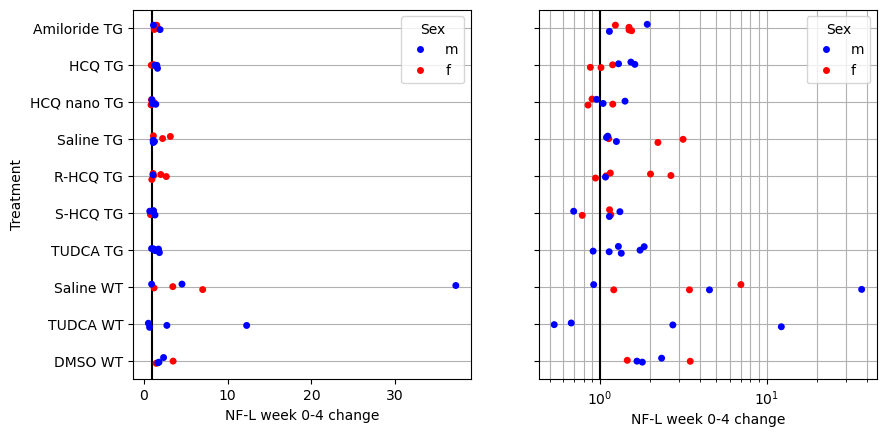

In [5]:
def stripplot_sex(data):
    fig, ax = plt.subplots(1, 2, sharey=True, figsize=(9.6, 4.8))
    for axi in ax:
        axi.axvline(1, color='k')
        sns.stripplot(data=data, x='NF-L week 0-4 change', y='Treatment', hue='Sex', palette={'m': 'blue', 'f': 'red'}, ax=axi)
        axi.grid(axis='y')
    
    ax[1].grid(axis='x', which='both')
    ax[1].set_xscale('log')
    return((fig, ax))

fig, ax = stripplot_sex(data_CO28152)
attila_utils.savefig(fig, 'nfl-stripplot-linear-log-scale-CO28152')

In [6]:
#fig, ax = stripplot_sex(data_CO28154)
#attila_utils.savefig(fig, 'nfl-stripplot-linear-log-scale-CO28154')

['named-figure/nfl-stripplot-week-4-8-12-CO28152.png',
 'named-figure/nfl-stripplot-week-4-8-12-CO28152.pdf']

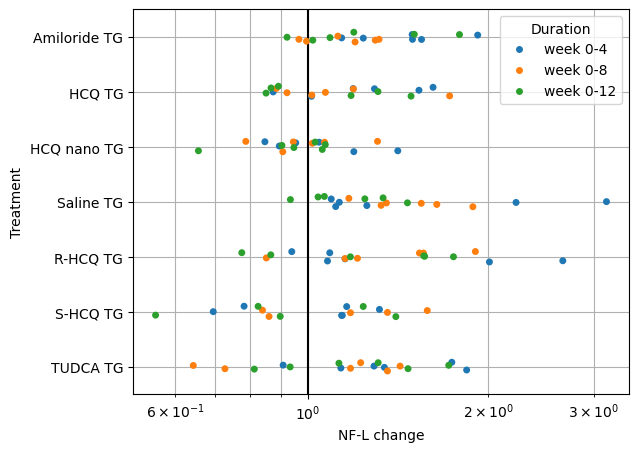

In [7]:
def stripplot_week(datalong):
    fig, ax = plt.subplots(figsize=(6.4, len(datalong.Treatment.unique()) / 2))
    ax.axvline(1, color='k')
    b = datalong.Treatment.apply(lambda x: bool(re.match('.*TG$', x)))
    sns.stripplot(data=datalong.loc[b], x='NF-L change', y='Treatment', hue='Duration', dodge=False, ax=ax)
    #sns.stripplot(data=datalong.loc[~ datalong.Treatment.isin(['Saline WT', 'TUDCA WT', 'DMSO WT'])], x='NF-L change', y='Treatment', hue='Duration', dodge=True, ax=ax)
    ax.grid(axis='x', which='both')
    ax.grid(axis='y')
    ax.set_xscale('log')
    return((fig, ax))

fig, ax = stripplot_week(datalong_CO28152)
attila_utils.savefig(fig, 'nfl-stripplot-week-4-8-12-CO28152')

In [8]:
#fig, ax = stripplot_week(datalong_CO28154)
#attila_utils.savefig(fig, 'nfl-stripplot-week-4-8-12-CO28154')

In [9]:
def make_datadict(data, categories=None):
    datad = {gt: data.loc[data.Treatment.apply(lambda x: bool(re.match('.*' + gt + '$', x)))] for gt in ['WT', 'TG']}
    l = [datad['TG'].loc[:, :'Genotype'], datad['TG'][['Treatment']], datad['TG'].loc[:, 'NF-L week 0-4 change':'NF-L week 0-12 change']]
    datad['TG'] = pd.concat(l, axis=1)
    newcol = 'NF-L week 0-4 or 0-8 change'
    l = [
        datad['TG'].loc[:, :'NF-L week 0-4 change'].rename({'NF-L week 0-4 change': newcol}, axis=1),
        datad['TG'].loc[:, :'NF-L week 0-8 change'].drop('NF-L week 0-4 change', axis=1).rename({'NF-L week 0-8 change': newcol}, axis=1)
        ]
    newkey = 'TG week 0-4 or 0-8'
    datad[newkey] = pd.concat(l, axis=0)
    datad[newkey]['IRN'] = datad[newkey].IRN.astype('str')
    return(datad)

categories_CO28152 = ['Saline TG', 'Amiloride TG', 'HCQ TG', 'HCQ nano TG', 'R-HCQ TG', 'S-HCQ TG', 'TUDCA TG']
categories_CO28154 = ['Saline TG', 'TUDCA + HCQ TG', 'Vehicle (Arundine) TG', 'Arundine low dose TG', 'Arundine mid dose TG', 'Arundine high dose TG']
datad_CO28152, datad_CO28154 = [make_datadict(d) for d in [data_CO28152, data_CO28154]]

['named-figure/nfl-stripplot-week-4-8-12-3panels-CO28152.png',
 'named-figure/nfl-stripplot-week-4-8-12-3panels-CO28152.pdf']

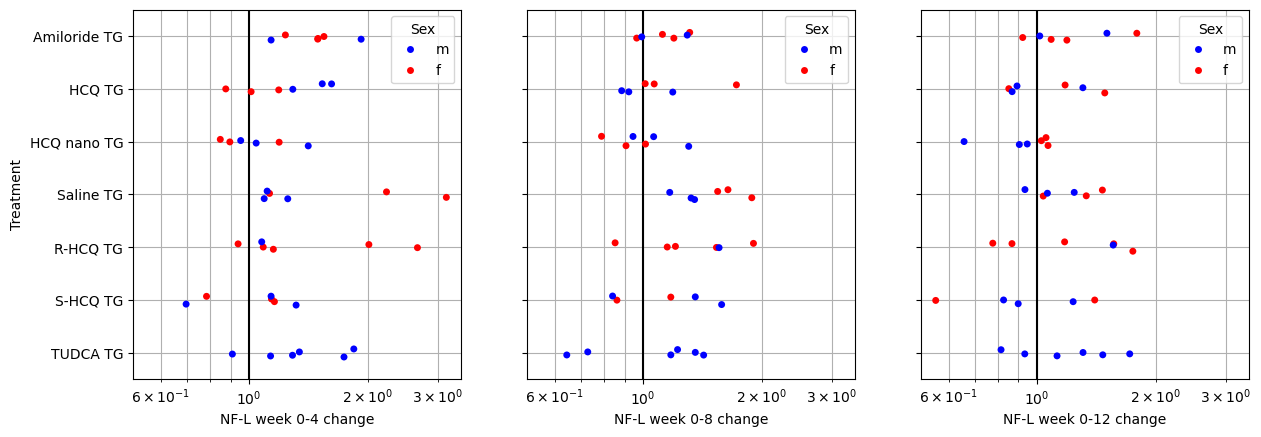

In [10]:
def stripplot_week(datad):
    fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(14.4, 4.8))
    for axi, x in zip(ax, ['NF-L week 0-4 change', 'NF-L week 0-8 change', 'NF-L week 0-12 change']):
        axi.axvline(1, color='k')
        sns.stripplot(data=datad['TG'], x=x, y='Treatment', hue='Sex', palette={'m': 'blue', 'f': 'red'}, ax=axi)
        axi.set_xscale('log')
        axi.grid(axis='x', which='both')
        axi.grid(axis='y')
    return((fig, ax))

fig, ax = stripplot_week(datad_CO28152)
attila_utils.savefig(fig, 'nfl-stripplot-week-4-8-12-3panels-CO28152')

In [11]:
#fig, ax = stripplot_week(datad_CO28154)
#attila_utils.savefig(fig, 'nfl-stripplot-week-4-8-12-3panels-CO28154')

## Fitting model

In [12]:
subset_CO28152 = ['Saline TG', 'Amiloride TG', 'HCQ TG', 'HCQ nano TG', 'R-HCQ TG', 'S-HCQ TG', 'TUDCA TG']
subset_CO28154_TUDCA_HCQ = ['Saline TG', 'TUDCA + HCQ TG']
subset_CO28154_Arundine = ['Vehicle (Arundine) TG', 'Arundine low dose TG', 'Arundine mid dose TG', 'Arundine high dose TG']

def subset_datad(datad=datad_CO28152, subset=subset_CO28152):
    def helper(data):
        df = data.loc[data.Treatment.isin(subset)].copy()
        df['Treatment'] = pd.Categorical(df.Treatment, categories=subset, ordered=True)
        return(df)
    datad_subset = {k: helper(datad[k]) for k in ['TG', 'TG week 0-4 or 0-8']}
    return(datad_subset)



In [13]:
def fit_results(datad, subset):
    datad_subset = subset_datad(datad, subset)
    formulas = {'week 0-' + week: 'np.log(Q("NF-L week 0-' + week + ' change")) ~ 1 + Treatment' for week in ['4', '8', '12']}
    resultd = {k: smf.ols(v, data=datad_subset['TG']).fit() for k, v in formulas.items()}
    formula = 'np.log(Q("NF-L week 0-4 or 0-8 change")) ~ 1 + Treatment'
    resultd['week 0-4 or 0-8'] = smf.ols(formula, data=datad_subset['TG week 0-4 or 0-8']).fit()
    return(resultd)

Z = zip([datad_CO28152, datad_CO28154, datad_CO28154], [subset_CO28152, subset_CO28154_TUDCA_HCQ, subset_CO28154_Arundine])
resultd_CO28152, resultd_CO28154_TUDCA_HCQ, resultd_CO28154_Arundine = [fit_results(datad, subset) for datad, subset in Z]
for k, v in resultd_CO28152.items():
    print(k)
    print(v.summary(), *list(np.repeat(['\n'], 3)))

week 0-4
                                    OLS Regression Results                                   
Dep. Variable:     np.log(Q("NF-L week 0-4 change"))   R-squared:                       0.220
Model:                                           OLS   Adj. R-squared:                  0.087
Method:                                Least Squares   F-statistic:                     1.647
Date:                               Wed, 10 Jul 2024   Prob (F-statistic):              0.163
Time:                                       01:18:21   Log-Likelihood:                -5.4543
No. Observations:                                 42   AIC:                             24.91
Df Residuals:                                     35   BIC:                             37.07
Df Model:                                          6                                         
Covariance Type:                           nonrobust                                         
                                coef    std err    

In [14]:
for k, v in resultd_CO28154_TUDCA_HCQ.items():
    print(k)
    print(v.summary(), *list(np.repeat(['\n'], 3)))

week 0-4
                                    OLS Regression Results                                   
Dep. Variable:     np.log(Q("NF-L week 0-4 change"))   R-squared:                       0.194
Model:                                           OLS   Adj. R-squared:                  0.113
Method:                                Least Squares   F-statistic:                     2.407
Date:                               Wed, 10 Jul 2024   Prob (F-statistic):              0.152
Time:                                       01:18:21   Log-Likelihood:                 3.4367
No. Observations:                                 12   AIC:                            -2.873
Df Residuals:                                     10   BIC:                            -1.904
Df Model:                                          1                                         
Covariance Type:                           nonrobust                                         
                                  coef    std err  

/Users/jonesa7/opt/anaconda3/envs/bayes/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1971: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  k, _ = kurtosistest(a, axis)
/Users/jonesa7/opt/anaconda3/envs/bayes/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1971: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  k, _ = kurtosistest(a, axis)
/Users/jonesa7/opt/anaconda3/envs/bayes/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1971: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  k, _ = kurtosistest(a, axis)


In [15]:
for k, v in resultd_CO28154_Arundine.items():
    print(k)
    print(v.summary(), *list(np.repeat(['\n'], 3)))

week 0-4
                                    OLS Regression Results                                   
Dep. Variable:     np.log(Q("NF-L week 0-4 change"))   R-squared:                       0.069
Model:                                           OLS   Adj. R-squared:                 -0.095
Method:                                Least Squares   F-statistic:                    0.4191
Date:                               Wed, 10 Jul 2024   Prob (F-statistic):              0.742
Time:                                       01:18:21   Log-Likelihood:              -0.023857
No. Observations:                                 21   AIC:                             8.048
Df Residuals:                                     17   BIC:                             12.23
Df Model:                                          3                                         
Covariance Type:                           nonrobust                                         
                                         coef    st

## Plotting results

In [16]:
def results2df(resultd, ref_treatment='Saline TG', study='CO28152', drop_intercept=False):
    def helper(duration):
        results = resultd[duration]
        df = pd.concat([results.params.to_frame('mean'),
                        results.bse.to_frame('bse'),
                        results.pvalues.to_frame('pval')], axis=1)
        df['treatment'] = [x.replace('Treatment[T.', '').replace(']', '') for x in df.index]
        df['reference treatment'] = ref_treatment
        df['study'] = study
        df['duration'] = duration
        ix = pd.MultiIndex.from_frame(df[['duration', 'treatment']])
        df = pd.DataFrame(df.to_numpy(), columns=df.columns, index=ix)
        return(df)
    l = [helper(d) for d in resultd.keys()]
    val = pd.concat(l, axis=0)
    val = val.drop('Intercept', axis=0, level=2) if drop_intercept else val
    return(val)

Z = zip([resultd_CO28152, resultd_CO28154_TUDCA_HCQ, resultd_CO28154_Arundine],
        ['Saline TG', 'Saline TG', 'Vehicle (Arundine) TG'],
        ['CO28152', 'CO28152', 'CO28152'])

results2df(resultd_CO28154_TUDCA_HCQ, ref_treatment='Saline TG', study='CO28154')
l = [results2df(d, r, s) for d, r, s in Z]
resultsdf_CO28152, resultsdf_CO28154_TUDCA_HCQ, resultsdf_CO28154_Arundine = l
pd.concat(l)

mean       bse      pval  \
duration        treatment                                             
week 0-4        Intercept              0.415257  0.123219  0.001843   
                Amiloride TG          -0.042839  0.174258  0.807244   
                HCQ TG                -0.212377  0.174258  0.231089   
                HCQ nano TG           -0.375013  0.174258  0.038371   
                R-HCQ TG              -0.095701  0.174258  0.586359   
                S-HCQ TG              -0.402777  0.174258   0.02682   
                TUDCA TG              -0.124807  0.174258  0.478608   
week 0-8        Intercept              0.384304  0.097921  0.000402   
                Amiloride TG          -0.253005  0.138481   0.07649   
                HCQ TG                -0.284535  0.138481   0.04766   
                HCQ nano TG           -0.391759  0.138481  0.007778   
                R-HCQ TG              -0.102735  0.138481  0.463263   
                S-HCQ TG              -0.263666   0.14524  0.078295   
                TUDCA TG              -0.340004  0.138481  0.019349   
week 0-12       Intercept              0.154076  0.108876   0.16612   
                Amiloride TG           0.044359  0.153974  0.775022   
                HCQ TG                -0.085032  0.153974  0.584393   
                HCQ nano TG            -0.22519  0.153974  0.152782   
                R-HCQ TG               0.049139  0.153974  0.751576   
                S-HCQ TG              -0.220931   0.16149   0.18026   
                TUDCA TG               0.019306  0.153974  0.900958   
week 0-4 or 0-8 Intercept               0.39978   0.07821  0.000002   
                Amiloride TG          -0.147922  0.110605  0.185085   
                HCQ TG                -0.248456  0.110605  0.027587   
                HCQ nano TG           -0.383386  0.110605  0.000871   
                R-HCQ TG              -0.099218  0.110605  0.372527   
                S-HCQ TG              -0.338138  0.113091  0.003758   
                TUDCA TG              -0.232405  0.110605  0.038937   
week 0-4        Intercept             -0.020298  0.081264  0.807818   
                TUDCA + HCQ TG         0.178315  0.114925  0.151808   
week 0-8        Intercept              0.141081  0.128047  0.296363   
                TUDCA + HCQ TG        -0.338311  0.181085  0.091271   
week 0-12       Intercept             -0.003628  0.087246  0.967648   
                TUDCA + HCQ TG        -0.041652  0.123384  0.742661   
week 0-4 or 0-8 Intercept              0.060392   0.08341  0.476676   
                TUDCA + HCQ TG        -0.079998   0.11796   0.50473   
week 0-4        Intercept              0.074876  0.109917   0.50492   
                Arundine low dose TG   0.154742  0.163034  0.355848   
                Arundine mid dose TG    0.15703  0.163034  0.348963   
                Arundine high dose TG  0.099155  0.163034  0.551102   
week 0-8        Intercept              0.040273  0.087442  0.650629   
                Arundine low dose TG  -0.185921  0.129698   0.16886   
                Arundine mid dose TG    -0.1639  0.129698  0.222459   
                Arundine high dose TG  -0.01991  0.123662  0.873886   
week 0-12       Intercept             -0.102689  0.154809   0.51553   
                Arundine low dose TG  -0.187914   0.22962  0.423848   
                Arundine mid dose TG    0.03705   0.22962  0.873612   
                Arundine high dose TG  0.042576  0.218934  0.847985   
week 0-4 or 0-8 Intercept              0.057574  0.077269  0.460671   
                Arundine low dose TG   -0.01559  0.114608    0.8925   
                Arundine mid dose TG  -0.003435  0.114608  0.976241   
                Arundine high dose TG  0.032638  0.111731   0.77175   

                                                   treatment  \
duration        treatment                                      
week 0-4        Intercept                          Intercept   
                

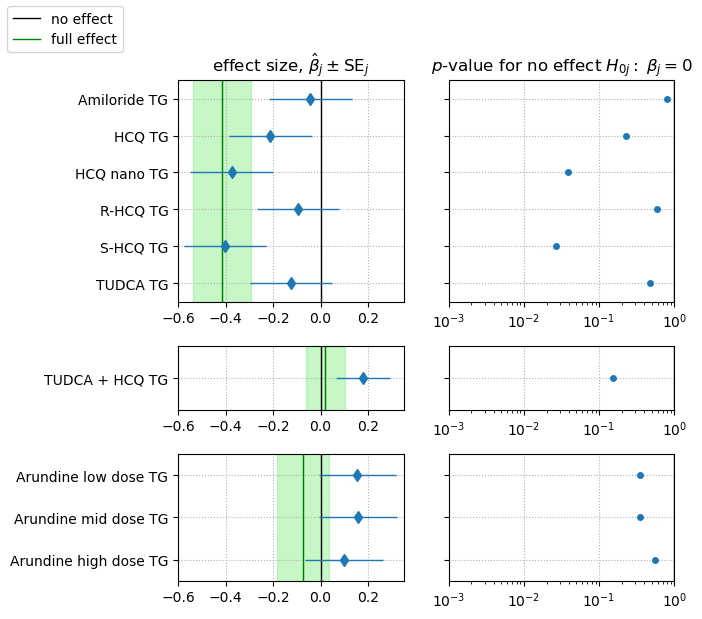

In [17]:
def result_plotter_ax(ax, df, suptitle=''):
    full_effect_mean, full_effect_se = df.loc['Intercept', ['mean', 'bse']]
    df = df.drop('Intercept', axis=0)
    rectL, rectR = [Rectangle(xy=(- full_effect_mean, -0.5), width=full_effect_se, height=df.shape[0] + 1, alpha=0.5, color='lightgreen', angle=a, rotation_point=(- full_effect_mean, df.shape[0]/2)) for a in [180, 0]]
    ax[0].add_patch(rectL)
    ax[0].add_patch(rectR)
    ax[0].axvline(0, color='k', linewidth=1)
    ax[0].axvline(- full_effect_mean, color='green', linewidth=1, linestyle='solid')
    ax[0].errorbar(y=np.arange(df.shape[0]), x=df['mean'], xerr=df['bse'], linewidth=0, elinewidth=1, marker='d', capsize=0)
    ax[0].set_title(r'effect size, $\hat{\beta}_j \pm \mathrm{SE}_j$')
    ax[1].axvline(1, color='k', linewidth=1)
    sns.stripplot(x='pval', y='treatment', ax=ax[1], data=df)
    ax[1].set_xscale('log')
    ax[1].set_xlabel('')
    ax[1].set_ylabel('')
    ax[1].set_title(r'$p$-value for no effect $H_{0j}: \; \beta_j = 0$')
    for j in range(2):
        axi = ax[j]
        axi.grid(linestyle='dotted')
        axi.set_yticks(list(range(len(df))))
        axi.set_ylim(len(df) - 0.5, -0.5)
    ax[0].set_yticklabels(df.treatment)
    ax[1].set_yticklabels('')
    return(ax)

def result_plotter(l_resultsdf, duration='week 0-4', hspace_denom=None, x0_lim=None, x1_lim=None):
    resl = [df.xs(duration, axis=0, level=0) for df in l_resultsdf]
    height_ratios = [len(df) for df in resl]
    hspace_denom = 40 if hspace_denom is None else hspace_denom
    gridspec_kw = {'hspace': sum(height_ratios) / hspace_denom}
    fig, ax = plt.subplots(len(resl), 2, figsize=(6.4, sum(height_ratios) * 0.5), height_ratios=height_ratios, squeeze=False, gridspec_kw=gridspec_kw)
    for i, res in enumerate(resl):
        axes = ax[i, :]
        axes = result_plotter_ax(axes, res)
        if x0_lim is not None:
            axes[0].set_xlim(*x0_lim)
        if x1_lim is not None:
            axes[1].set_xlim(*x1_lim)
        if i > 0:
            [axes[j].set_title('') for j in range(2)]
    black_line, green_line = [mlines.Line2D([], [], color=color, marker=None, linewidth=1, label=label) for color, label in zip(['black', 'green'], ['no effect', 'full effect'])]
    fig.legend(handles=[black_line, green_line], loc='upper left')
    return((fig, ax))


l_resultsdf = [resultsdf_CO28152, resultsdf_CO28154_TUDCA_HCQ, resultsdf_CO28154_Arundine]
fig, ax = result_plotter(l_resultsdf, duration='week 0-4', x0_lim=(-0.6, 0.35), x1_lim=(1e-3, 1))

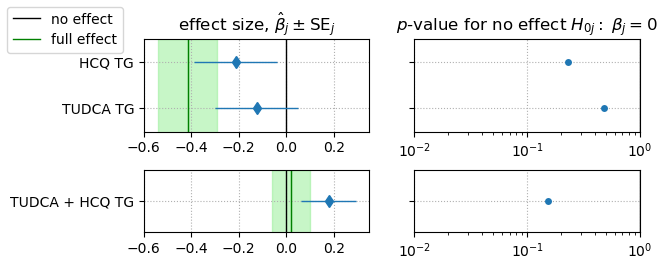

In [21]:
l_resultsdf = [resultsdf_CO28152.loc[resultsdf_CO28152.treatment.isin(['Intercept', 'HCQ TG', 'TUDCA TG'])], resultsdf_CO28154_TUDCA_HCQ]
fig, ax = result_plotter(l_resultsdf, duration='week 0-4', hspace_denom=10, x0_lim=(-0.6, 0.35), x1_lim=(1e-2, 1))

In [18]:
%connect_info

{
  "shell_port": 55015,
  "iopub_port": 55016,
  "stdin_port": 55017,
  "control_port": 55019,
  "hb_port": 55018,
  "ip": "127.0.0.1",
  "key": "7cdfd215-2846bb60cd8c96ec29d9e33c",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": "python3",
  "jupyter_session": "/Users/jonesa7/CTNS/notebooks/2024-01-05-5xfad-nfl-frequentist/2024-01-05-5xfad-nfl-frequentist.ipynb"
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-b88c42c9-8cd1-4261-a789-6054f8b8f757.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
